## Problema de negócio
Prever o comportamento para reter clientes. Analisar todos os dados relevantes dos clientes e desenvolver programa que prevê a possibilidade de saída de clientes

## Análise exploratória dos dados (EDA)

In [83]:
# bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import ExtraTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import joblib

import time


In [84]:
# carregar dados

dados = pd.read_csv("dados/WA_Fn-UseC_-Telco-Customer-Churn.csv")

dados.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [85]:
# tamanho do dataset
dados.shape

(7043, 21)

In [86]:
# features existentes
dados.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [87]:

def trata_nome_coluna(nome):
    resultado = [nome[0]]
    for x in nome[1:]:
        #se a partir da segunda letra, encontrar um "_" e dois caracteres atrás nao for um "_", inclue o "_"
        if (x.isupper()and resultado[-2] != "_"):
            resultado.extend(["_", x])
        else:
            resultado.append(x)
    
    resultado = ''.join(resultado).lower()
    
    return resultado

for col in dados.columns:
    novo_nome = trata_nome_coluna(col)  
    #dados = dados.rename(columns={col : novo_nome})
    
dados.head(3)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [88]:
dic_colunas = {
    'customerID' : 'ID Cliente', 
    'gender' : 'Sexo', 
    'SeniorCitizen' : 'Idoso', 
    'Partner' : 'Possui parceiro', 
    'Dependents' : 'Possui dependentes',
    'tenure' : 'Meses como cliente', 
    'PhoneService' : 'Possui serviço telefônico', 
    'MultipleLines' : 'Possui múltiplas linhas', 
    'InternetService' : 'Internet',
    'OnlineSecurity' : 'Possui serviço de segurança online', 
    'OnlineBackup' : 'Possui serviço de backup online', 
    'DeviceProtection': 'Possui plano de proteção de dispositivo', 
    'TechSupport' : 'Possui suporte técnico',
    'StreamingTV' : 'Possui pacote de TV', 
    'StreamingMovies' : 'Possui pacote de filmes', 
    'Contract' : 'Contrato', 
    'PaperlessBilling' : 'Fatura online',
    'PaymentMethod' : 'Pagamento', 
    'MonthlyCharges' : 'Fatura mensal', 
    'TotalCharges' : 'Total de encargos trimestrais', 
    'Churn' : 'Cliente cancelou contrato'}

dados.rename(columns=dic_colunas, inplace=True)

dados

,ID Cliente,Sexo,Idoso,Possui parceiro,Possui dependentes,Meses como cliente,Possui serviço telefônico,Possui múltiplas linhas,Internet,Possui serviço de segurança online,...,Possui plano de proteção de dispositivo,Possui suporte técnico,Possui pacote de TV,Possui pacote de filmes,Contrato,Fatura online,Pagamento,Fatura mensal,Total de encargos trimestrais,Cliente cancelou contrato
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [89]:
# dados faltantes
dados.isna().sum()

ID Cliente                                 0
Sexo                                       0
Idoso                                      0
Possui parceiro                            0
Possui dependentes                         0
Meses como cliente                         0
Possui serviço telefônico                  0
Possui múltiplas linhas                    0
Internet                                   0
Possui serviço de segurança online         0
Possui serviço de backup online            0
Possui plano de proteção de dispositivo    0
Possui suporte técnico                     0
Possui pacote de TV                        0
Possui pacote de filmes                    0
Contrato                                   0
Fatura online                              0
Pagamento                                  0
Fatura mensal                              0
Total de encargos trimestrais              0
Cliente cancelou contrato                  0
dtype: int64

In [90]:
# dados duplicados
dados.duplicated().sum()

0

In [91]:
dados.head()

,ID Cliente,Sexo,Idoso,Possui parceiro,Possui dependentes,Meses como cliente,Possui serviço telefônico,Possui múltiplas linhas,Internet,Possui serviço de segurança online,...,Possui plano de proteção de dispositivo,Possui suporte técnico,Possui pacote de TV,Possui pacote de filmes,Contrato,Fatura online,Pagamento,Fatura mensal,Total de encargos trimestrais,Cliente cancelou contrato
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [92]:

for col in dados.columns:
    if col == "ID Cliente":
        continue
    
    print(f"\n\n==========={col}=============")
    print(dados[col].value_counts())



===========Sexo=============
Sexo
Male      3555
Female    3488
Name: count, dtype: int64


===========Idoso=============
Idoso
0    5901
1    1142
Name: count, dtype: int64


===========Possui parceiro=============
Possui parceiro
No     3641
Yes    3402
Name: count, dtype: int64


===========Possui dependentes=============
Possui dependentes
No     4933
Yes    2110
Name: count, dtype: int64


===========Meses como cliente=============
Meses como cliente
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64


===========Possui serviço telefônico=============
Possui serviço telefônico
Yes    6361
No      682
Name: count, dtype: int64


===========Possui múltiplas linhas=============
Possui múltiplas linhas
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64


===========Internet=============
Internet
Fiber optic    3096
DSL            2421
No 

## Pré processamento dos dados

**Legenda**

Para todas as colunas:
* Sim == 1
* Não == 0

In [93]:
#remove colunas desnecessárias
dados.drop(columns=['ID Cliente'], inplace=True)

In [94]:
# codifica a coluna 'Sexo', e renomeia para 'Feminino'
dados['Sexo'] = dados['Sexo'].apply(lambda x : 1 if x == 'Female' else 0)

dados.rename(columns={'Sexo' : 'Feminino'}, inplace=True)


In [95]:
# codifica as colunas Yes / No para 1 / 0

cols_sim_nao = ['Idoso', 'Possui parceiro',
       'Possui dependentes', 'Possui serviço telefônico',
       'Possui múltiplas linhas', 
       'Possui serviço de segurança online', 'Possui serviço de backup online',
       'Possui plano de proteção de dispositivo', 'Possui suporte técnico',
       'Possui pacote de TV', 'Possui pacote de filmes', 'Cliente cancelou contrato', 'Fatura online']

for col in cols_sim_nao:
    dados[col] = dados[col].apply(lambda x : 1 if (x == 'Yes' or x == 1) else 0)
    print(dados[col].value_counts())

Idoso
0    5901
1    1142
Name: count, dtype: int64
Possui parceiro
0    3641
1    3402
Name: count, dtype: int64
Possui dependentes
0    4933
1    2110
Name: count, dtype: int64
Possui serviço telefônico
1    6361
0     682
Name: count, dtype: int64
Possui múltiplas linhas
0    4072
1    2971
Name: count, dtype: int64
Possui serviço de segurança online
0    5024
1    2019
Name: count, dtype: int64
Possui serviço de backup online
0    4614
1    2429
Name: count, dtype: int64
Possui plano de proteção de dispositivo
0    4621
1    2422
Name: count, dtype: int64
Possui suporte técnico
0    4999
1    2044
Name: count, dtype: int64
Possui pacote de TV
0    4336
1    2707
Name: count, dtype: int64
Possui pacote de filmes
0    4311
1    2732
Name: count, dtype: int64
Cliente cancelou contrato
0    5174
1    1869
Name: count, dtype: int64
Fatura online
1    4171
0    2872
Name: count, dtype: int64


In [96]:
#força a conversão da coluna para numérica
dados['Total de encargos trimestrais'] = pd.to_numeric(dados['Total de encargos trimestrais'], errors='coerce')


In [97]:
# preenche os dados nulos com a mediana
dados['Total de encargos trimestrais'] = dados['Total de encargos trimestrais'].fillna(dados['Total de encargos trimestrais'].median())

In [98]:
dados.isna().sum()

Feminino                                   0
Idoso                                      0
Possui parceiro                            0
Possui dependentes                         0
Meses como cliente                         0
Possui serviço telefônico                  0
Possui múltiplas linhas                    0
Internet                                   0
Possui serviço de segurança online         0
Possui serviço de backup online            0
Possui plano de proteção de dispositivo    0
Possui suporte técnico                     0
Possui pacote de TV                        0
Possui pacote de filmes                    0
Contrato                                   0
Fatura online                              0
Pagamento                                  0
Fatura mensal                              0
Total de encargos trimestrais              0
Cliente cancelou contrato                  0
dtype: int64

In [99]:
# altera os dados de contrato
dados['Contrato'] = dados['Contrato'].apply(lambda x : 'Anual' if x == 'One year' else 'Bienal' if x == 'Two year' else 'Mensal' if x == 'Month-to-month' else x)


In [100]:
ohe = OneHotEncoder()
contrato_ohe = ohe.fit_transform(dados[['Contrato']])


In [101]:
contrato_df = pd.DataFrame(data=contrato_ohe.toarray(), columns=ohe.get_feature_names_out())

dados = pd.concat([dados, contrato_df], axis="columns")


In [102]:
# altera os dados de meio de pagamento
dados['Pagamento'].value_counts()

Pagamento
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

In [103]:
dados['Pagamento'] = dados['Pagamento'].map({
    'Electronic check' : 'Cheque_eletronico',
    'Mailed check' : 'Cheque',
    'Bank transfer (automatic)' : 'Transferencia_bancaria',
    'Credit card (automatic)' : 'Cartao_Credito'
    })

dados['Pagamento'].value_counts()

Pagamento
Cheque_eletronico         2365
Cheque                    1612
Transferencia_bancaria    1544
Cartao_Credito            1522
Name: count, dtype: int64

In [104]:
ohe = OneHotEncoder()
pagamento_ohe = ohe.fit_transform(dados[['Pagamento']])

pagamento_df = pd.DataFrame(data=pagamento_ohe.toarray(), columns=ohe.get_feature_names_out())

dados = pd.concat([dados, pagamento_df], axis="columns")


In [105]:
# altera os dados se Possui serviço de internet
dados['Internet'] = dados['Internet'].map({
    'Fiber optic' : 'Fibra',
    'DSL' : 'DSL',
    'No' : 'Nao'
})


In [106]:

ohe = OneHotEncoder()
internet_ohe = ohe.fit_transform(dados[['Internet']])

internet_df = pd.DataFrame(data=internet_ohe.toarray(), columns=ohe.get_feature_names_out())

dados = pd.concat([dados, internet_df], axis="columns")

dados

,Feminino,Idoso,Possui parceiro,Possui dependentes,Meses como cliente,Possui serviço telefônico,Possui múltiplas linhas,Internet,Possui serviço de segurança online,Possui serviço de backup online,...,Contrato_Anual,Contrato_Bienal,Contrato_Mensal,Pagamento_Cartao_Credito,Pagamento_Cheque,Pagamento_Cheque_eletronico,Pagamento_Transferencia_bancaria,Internet_DSL,Internet_Fibra,Internet_Nao
0,1,0,1,0,1,0,0,DSL,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0,0,0,0,34,1,0,DSL,1,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,0,0,0,2,1,0,DSL,1,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,0,0,0,45,0,0,DSL,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1,0,0,0,2,1,0,Fibra,0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,1,DSL,1,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7039,1,0,1,1,72,1,1,Fibra,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7040,1,0,1,1,11,0,0,DSL,1,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7041,0,1,1,0,4,1,1,Fibra,0,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [107]:
dados.columns

Index(['Feminino', 'Idoso', 'Possui parceiro', 'Possui dependentes',
       'Meses como cliente', 'Possui serviço telefônico',
       'Possui múltiplas linhas', 'Internet',
       'Possui serviço de segurança online', 'Possui serviço de backup online',
       'Possui plano de proteção de dispositivo', 'Possui suporte técnico',
       'Possui pacote de TV', 'Possui pacote de filmes', 'Contrato',
       'Fatura online', 'Pagamento', 'Fatura mensal',
       'Total de encargos trimestrais', 'Cliente cancelou contrato',
       'Contrato_Anual', 'Contrato_Bienal', 'Contrato_Mensal',
       'Pagamento_Cartao_Credito', 'Pagamento_Cheque',
       'Pagamento_Cheque_eletronico', 'Pagamento_Transferencia_bancaria',
       'Internet_DSL', 'Internet_Fibra', 'Internet_Nao'],
      dtype='object')

In [108]:
#remove as colunas após one hot enconder
dados.drop(columns=['Pagamento', 'Internet', 'Contrato', 'Pagamento',
                    'Pagamento_Transferencia_bancaria',
                    'Internet_Nao', 'Contrato_Mensal'], inplace=True)


In [109]:
# quantidade de produtos que o cliente possui em uma nova coluna, e remove as existentes
dados['total_produtos'] = dados[['Possui serviço telefônico', 'Possui múltiplas linhas', 'Possui serviço de segurança online',
      'Possui serviço de backup online','Possui plano de proteção de dispositivo', 'Possui suporte técnico',
      'Possui pacote de TV', 'Possui pacote de filmes', 'Internet_DSL', 'Internet_Fibra']].sum(axis='columns')

dados.drop(columns=['Possui serviço telefônico', 'Possui múltiplas linhas', 'Possui serviço de segurança online',
      'Possui serviço de backup online','Possui plano de proteção de dispositivo', 'Possui suporte técnico',
      'Possui pacote de TV', 'Possui pacote de filmes', 'Internet_DSL', 'Internet_Fibra'], inplace=True)

dados

,Feminino,Idoso,Possui parceiro,Possui dependentes,Meses como cliente,Fatura online,Fatura mensal,Total de encargos trimestrais,Cliente cancelou contrato,Contrato_Anual,Contrato_Bienal,Pagamento_Cartao_Credito,Pagamento_Cheque,Pagamento_Cheque_eletronico,total_produtos
0,1,0,1,0,1,1,29.85,29.85,0,0.0,0.0,0.0,0.0,1.0,2.0
1,0,0,0,0,34,0,56.95,1889.50,0,1.0,0.0,0.0,1.0,0.0,4.0
2,0,0,0,0,2,1,53.85,108.15,1,0.0,0.0,0.0,1.0,0.0,4.0
3,0,0,0,0,45,0,42.30,1840.75,0,1.0,0.0,0.0,0.0,0.0,4.0
4,1,0,0,0,2,1,70.70,151.65,1,0.0,0.0,0.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,84.80,1990.50,0,1.0,0.0,0.0,1.0,0.0,8.0
7039,1,0,1,1,72,1,103.20,7362.90,0,1.0,0.0,1.0,0.0,0.0,7.0
7040,1,0,1,1,11,1,29.60,346.45,0,0.0,0.0,0.0,0.0,1.0,2.0
7041,0,1,1,0,4,1,74.40,306.60,1,0.0,0.0,0.0,1.0,0.0,3.0


<Axes: >

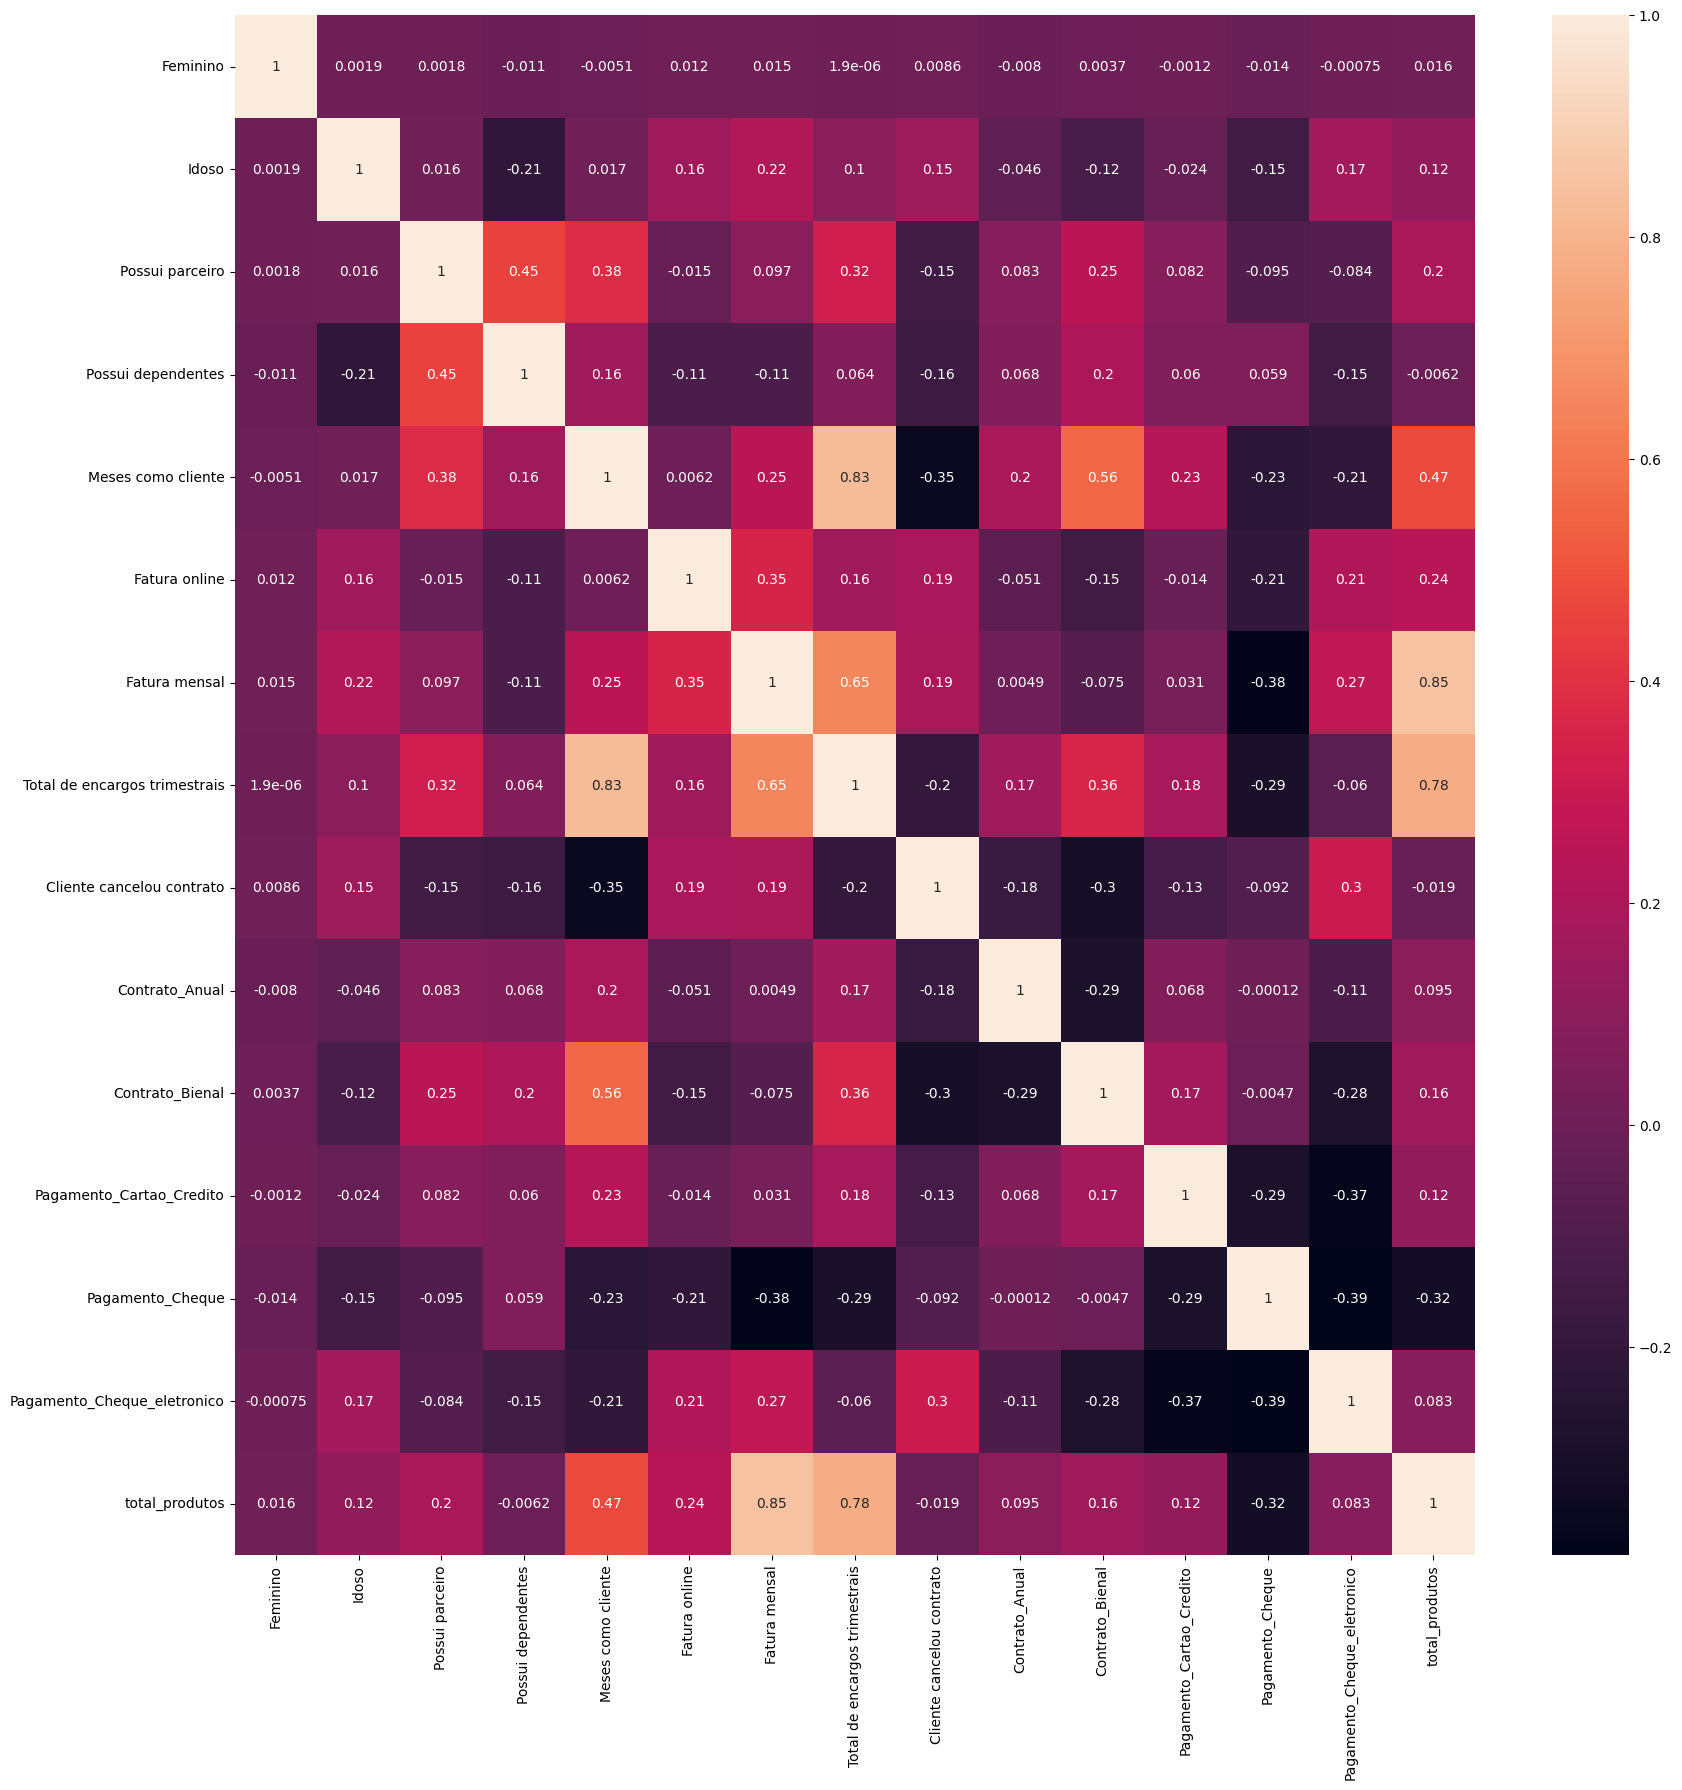

In [110]:
#correlação dos dados
plt.figure(figsize=(20,20))
sns.heatmap(dados.corr(), annot=True)

In [111]:
#remover a coluna 'Total de encargos trimestrais' por ser muito correlacionado com outras colunas
dados.drop(columns=['Total de encargos trimestrais'], inplace=True)

In [112]:
dados['Cliente cancelou contrato'].value_counts()

Cliente cancelou contrato
0    5174
1    1869
Name: count, dtype: int64

## Baseline dos modelos preditivos

In [113]:
from sklearn.model_selection import train_test_split
#separa as features da variavel target
dados_x = dados.drop(columns=['Cliente cancelou contrato'])
#dados_x = dados[['Fatura mensal', 'Meses como cliente', 'total_produtos']] #teste com apenas as melhores features
dados_y = dados['Cliente cancelou contrato']


In [114]:
#balancear os dados
from imblearn.over_sampling import SMOTE

smote = SMOTE()

dados_x, dados_y = smote.fit_resample(X=dados_x, y=dados_y)

dados_y

0        0
1        0
2        1
3        0
4        1
        ..
10343    1
10344    1
10345    1
10346    1
10347    1
Name: Cliente cancelou contrato, Length: 10348, dtype: int64

In [115]:
# separa os dados de treino e teste
x_train, x_test, y_train, y_test = train_test_split(dados_x, dados_y, test_size=0.25, random_state=7)

In [ ]:
# escolha das melhores features

modelo = ExtraTreeClassifier(random_state=None)

modelo.fit(x_train, y_train)

# Cria um DataFrame para melhor visualização
feature_importance_df = pd.DataFrame({'Feature': dados_x.columns, 'Importance': modelo.feature_importances_})

# Ordena o DataFrame pela importância
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(list(feature_importance_df['Feature'][:]))
sns.barplot(data=feature_importance_df[:], x='Importance', y='Feature', hue='Feature')

In [117]:
def imprime_modelo(nome, tempo_inicial, tempo_final, y_test, y_predict):
    print(f"\n==========={nome}==========")    
    print(f"Tempo gasto: {(tempo_final - tempo_inicial):.2f} segundos")
    print(f"Acuracia: {accuracy_score(y_test, y_predict)*100 :.2f}")
    print(confusion_matrix(y_test, y_predict))
    #print(classification_report(y_test, y_predict))

In [ ]:
# escolha do modelo preditivo
modelos = {
    "LogisticRegression" : LogisticRegression(), 
    "SGDClassifier" : SGDClassifier(), 
    "SVC" : SVC(), 
    "DecisionTreeClassifier" : DecisionTreeClassifier(), 
    "ExtraTreeClassifier" : ExtraTreeClassifier(), 
    "AdaBoostClassifier" : AdaBoostClassifier(), 
    "GradientBoostingClassifier" : GradientBoostingClassifier(), 
    "RandomForestClassifier" : RandomForestClassifier(), 
    "XGBClassifier" : XGBClassifier(),
    "LGBMClassifier" : LGBMClassifier(verbosity=0),
    "CatBoostClassifier" : CatBoostClassifier(silent=True)
}

for nome, modelo in modelos.items():
    tempo_inicial = time.time()
    modelo.fit(x_train, y_train)    
    y_predict = modelo.predict(x_test)
    tempo_final = time.time()
    
    imprime_modelo(nome, tempo_inicial, tempo_final, y_test, y_predict)


In [ ]:
# escolha dos parametros do XGBClassifier
from sklearn.model_selection import GridSearchCV

hiper_param = {
    'booster' : ['gbtree', 'gblinear', 'dart'], #default gbtree
    'eta' : [0.3, 0.1], #default 0.3
    'max_depth' : [4, 6, 8], #default 6
    'max_leaves' : [30, 40, 50],
    'random_state' : [7]
}

modelo = GridSearchCV(estimator=XGBClassifier(), param_grid=hiper_param, cv=7, scoring='accuracy')
modelo.fit(x_train, y_train)
print("Melhores features XGBClassifier\n", modelo.best_params_)

In [ ]:
# modelo preditivo definitivo

hiper_param_xgbc = {
    #'booster': 'gbtree', 
    #'eta': 0.3, 
    #'max_depth': 6, 
    'max_leaves': 50, 
    'random_state': 7
}

## os hiperparametros padrões foram os melhores

tempo_inicial = time.time()
modelo = XGBClassifier(**hiper_param_xgbc)

modelo.fit(x_train, y_train)

y_predict = modelo.predict(x_test)

tempo_final = time.time()

imprime_modelo("XGBClassifier", tempo_inicial, tempo_final, y_test, y_predict)

In [118]:
#criacao do modelo preditivo, com uso do pipeline
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("modelo", XGBClassifier(max_leaves = 50))
]
)


tempo_inicial = time.time()
pipeline.fit(x_train, y_train)

y_predict = pipeline.predict(x_test)

tempo_final = time.time()

imprime_modelo("XGBClassifier", tempo_inicial, tempo_final, y_test, y_predict)

joblib.dump(pipeline, "modelo_preditivo.joblib")



===========XGBClassifier==========
Tempo gasto: 0.38 segundos
Acuracia: 83.53
[[1049  256]
 [ 170 1112]]


['modelo_preditivo.joblib']

<Axes: >

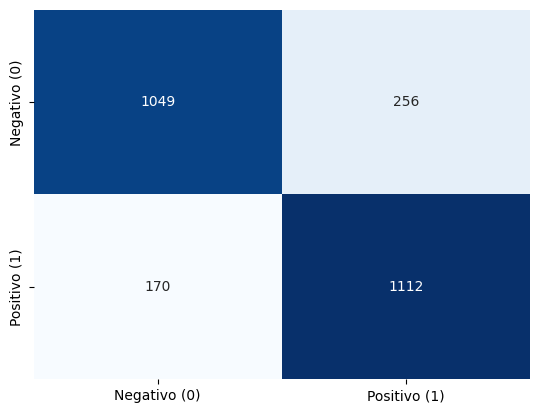

In [120]:
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Negativo (0)', 'Positivo (1)'], 
            yticklabels=['Negativo (0)', 'Positivo (1)'])